#EECS 442 PS6: Image Translation

Calvin Tran, cktran



# Starting

Run the following code to import the modules you'll need. After you finish the assignment, remember to run all cells and convert the notebook to a .pdf file for Gradescope submission.

In [1]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111
Using the GPU!


# Problem 6.1 pix2pix
You will build pix2pix for image translation. 

In this question, you will need to:

1. Contruct dataloaders for train/test datasets
2. Build Generator and Discriminator
3. Train pix2pix and visualize the results during training
4. Plot the loss of generator/discriminator v.s. iteration
5. Design your own shoes/Pokemon

**Optional**: set Pokemon_trainer to true and retrain the models if you want to apply pix2pix to Pokemon images instead of shoes. You also need to change the data loader to read from the pokemon folder instead of mini-edges2shoes.

In [2]:
Pokemon_trainer = False

## Step 0: Downloading the dataset.

We first download the `mini-edges2shoes` dataset sampled from the original `edges2shoes` dataset. The `mini-edges2shoes` dataset contains 1,000 training image pairs, and 100 testing image pairs.

Alternatively, we can download the `Pokemon` dataset, which contains 720 training image pairs, and 81 validation image pairs. 

There's nothing you need to implement for this part.

In [3]:
if Pokemon_trainer:
  # Download the Pokemon Images Dataset
  !rm -r pokemon.zip
  !rm -r pokemon
  !wget https://www.eecs.umich.edu/courses/eecs442-ahowens/fa21/data/pokemon.zip
  !unzip -q pokemon.zip
else:
  # Download the mini-edges2shoes dataset
  !rm -r mini-edges2shoes.zip
  !rm -r mini-edges2shoes
  !wget http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
  !unzip -q mini-edges2shoes.zip

rm: cannot remove 'mini-edges2shoes.zip': No such file or directory
rm: cannot remove 'mini-edges2shoes': No such file or directory
--2021-10-27 19:20:47--  http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48660290 (46M) [application/zip]
Saving to: ‘mini-edges2shoes.zip’

mini-edges2shoes.zi 100%[===================>]  46.41M  5.84MB/s    in 15s     

2021-10-27 19:21:03 (3.03 MB/s) - ‘mini-edges2shoes.zip’ saved [48660290/48660290]



## Step 1: Build dataloaders for train and test

We will first build dataloaders with PyTorch built-in classes. 

In [4]:
class Edges2Image(Dataset):
  def __init__(self, root_dir, split='train', transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """

    self.transform = transform
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    # get the the file path to all train/val images
    # Hint: the function glob.glob is useful
    self.files = glob.glob(root_dir + '/' + split + '/*')

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.files[idx])
    img = np.asarray(img)
    if self.transform:
        img = self.transform(img)
    return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== #
# Construct the dataloader
# For the train_loader, please use a batch size of 4 and set shuffle to True
# For the val_loader, please use a batch size of 5 and set shuffle to False
# Hint: please use the DataLoader from torch.utils.data
# TODO: change the folder name if you decide to use the Pokemon dataset instead

if Pokemon_trainer:
  dir = './pokemon'
else:
  dir = './mini-edges2shoes'

tr_dt = Edges2Image(root_dir=dir, transform=transform)
train_loader = DataLoader(tr_dt, batch_size=4, shuffle=True)

te_dt = Edges2Image(root_dir=dir, split='val', transform=transform)
test_loader = DataLoader(te_dt, batch_size=5, shuffle=False)

# ============== END OF CODE ================= # 
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#

# Make sure that you have 1,000 training images and 100 testing images before moving on
print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

Number of training images 1000, number of testing images 100


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


250
20
torch.Size([5, 3, 256, 256])


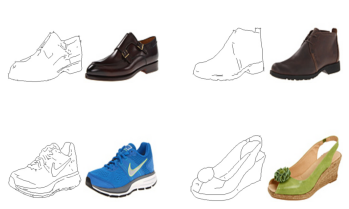

In [5]:
# Sample Output used for visualization
test = test_loader.__iter__().__next__()
img_size = 256
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  example = std * example + mean
  axes[i].imshow(example)
  axes[i].axis('off')
plt.show()

## Step 2: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

C512-C512-C512-C512-C256-C128-C64-C3

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

We have included a toy example of a U-net architecture below.


In [6]:
# (Not a part of your solution) Toy example of an U-net architecture
class toy_unet(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    # encoder
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    # decoder C128-C64-C3
    self.deconv1 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1)
    self.deconv2 = nn.ConvTranspose2d(64 * 2 * 2, 64, 4, 2, 1)
    self.deconv3 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1)

  # forward method
  def forward(self, input):
    # pass through encoder
    e1 = self.conv1(input)
    e2 = self.conv2(F.relu(e1))
    e3 = self.conv3(F.relu(e2, 0.2))
    # pass through decoder
    d1 = self.deconv1(F.relu(e3))
    d1 = torch.cat([d1, e2], 1) # Concatenation
    d2 = self.deconv2(F.relu(d1))
    d2 = torch.cat([d2, e1], 1) # Concatenation
    d3 = self.deconv3(F.relu(d2))
    return d3

In [7]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()
    # delete end

In [8]:
class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    # Unet encoder
    # C64-C128-C256-C512-C512-C512-C512-C512
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1)
    self.conv5 = nn.Conv2d(64 * 8, 64 * 8, 4, 2, 1)
    self.conv6 = nn.Conv2d(64 * 8, 64 * 8, 4, 2, 1)
    self.conv7 = nn.Conv2d(64 * 8, 64 * 8, 4, 2, 1)
    self.conv8 = nn.Conv2d(64 * 8, 64 * 8, 4, 2, 1)

    # Unet decoder
    # C512-C512-C512-C512-C256-C128-C64-C3
    self.deconv1 = nn.ConvTranspose2d(64 * 8, 64 * 8, 4, 2, 1)
    self.deconv2 = nn.ConvTranspose2d(64 * 8 * 2, 64 * 8, 4, 2, 1)
    self.deconv3 = nn.ConvTranspose2d(64 * 8 * 2, 64 * 8, 4, 2, 1)
    self.deconv4 = nn.ConvTranspose2d(64 * 8 * 2, 64 * 8, 4, 2, 1)
    self.deconv5 = nn.ConvTranspose2d(64 * 8 * 2, 64 * 4, 4, 2, 1)
    self.deconv6 = nn.ConvTranspose2d(64 * 4 * 2, 64 * 2, 4, 2, 1)
    self.deconv7 = nn.ConvTranspose2d(64 * 2 * 2, 64, 4, 2, 1)
    self.deconv8 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1)
    
    self.bn64 = nn.BatchNorm2d(64)
    self.bn128 = nn.BatchNorm2d(64 * 2)
    self.bn256 = nn.BatchNorm2d(64 * 4)
    self.bn512 = nn.BatchNorm2d(64 * 8)

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # encoding                                        # Layer
    e1 = self.conv1(input)                            # 1
    e2 = self.bn128(self.conv2(F.leaky_relu(e1, 0.2)))      # 2 + 3
    e3 = self.bn256(self.conv3(F.leaky_relu(e2, 0.2)))      # 4 + 5
    e4 = self.bn512(self.conv4(F.leaky_relu(e3, 0.2)))      # 6 + 7
    e5 = self.bn512(self.conv5(F.leaky_relu(e4, 0.2)))      # 8 + 9
    e6 = self.bn512(self.conv6(F.leaky_relu(e5, 0.2)))      # 10 + 11
    e7 = self.bn512(self.conv7(F.leaky_relu(e6, 0.2)))      # 12 + 13
    e8 = self.conv8(F.leaky_relu(e7, 0.2))                  # 14
    
    # decoding
    # Hint: you can use torch.cat to concatenate the decoder and the encoder inputs
    d1 = self.deconv1(F.relu(e8))                 # 15
    d1 = self.bn512(d1)                           # 16
    d1 = torch.cat([d1, e7], 1) # Concatenation

    d2 = self.deconv2(F.relu(d1))                 # 17
    d2 = self.bn512(d2)                           # 18
    d2 = torch.cat([d2, e6], 1) # Concatenation

    d3 = self.deconv3(F.relu(d2))                 # 19
    d3 = self.bn512(d3)                           # 20
    d3 = torch.cat([d3, e5], 1) # Concatenation

    d4 = self.deconv4(F.relu(d3))                 # 21
    d4 = self.bn512(d4)                           # 22
    d4 = torch.cat([d4, e4], 1) # Concatenation

    d5 = self.deconv5(F.relu(d4))                 # 23
    d5 = self.bn256(d5)                           # 24
    d5 = torch.cat([d5, e3], 1) # Concatenation

    d6 = self.deconv6(F.relu(d5))                 # 25
    d6 = self.bn128(d6)                           # 26
    d6 = torch.cat([d6, e2], 1) # Concatenation

    d7 = self.deconv7(F.relu(d6))                 # 27
    d7 = self.bn64(d7)                            # 28
    d7 = torch.cat([d7, e1], 1) # Concatenation

    d8 = self.deconv8(F.relu(d7))                 # 29

    output = torch.tanh(d8)
    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return output

# After the last layer, a convolution is applied to map to a 1-dimensional 
# output, followed by a Sigmoid function. As an exception to the above 
# notation, BatchNorm is not applied to the first C64 layer. 
# All ReLUs are leaky, with slope 0.2.
class discriminator(nn.Module):
  # initializers
  def __init__(self):
    super(discriminator, self).__init__()
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # C64-C128-C256-C512
    self.conv1 = nn.Conv2d(6, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.bn128 = nn.BatchNorm2d(64 * 2)
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    self.bn256 = nn.BatchNorm2d(64 * 4)
    self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 1, 1)
    self.bn512 = nn.BatchNorm2d(64 * 8)
    self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 1)
    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    e1 = self.conv1(input)
    e2 = self.conv2(F.leaky_relu(e1, 0.2))
    e3 = self.bn128(e2)
    e4 = self.conv3(F.leaky_relu(e3, 0.2))
    e5 = self.bn256(e4)
    e6 = self.conv4(F.leaky_relu(e5, 0.2))
    e7 = self.bn512(e6)
    e8 = self.conv5(F.leaky_relu(e7, 0.2))

    x = torch.sigmoid(e8)
    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return x

In [9]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 51

In [10]:
D

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [11]:
G

generator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

**Make sure your model architecturees summary from the above cell match with the given architecture below.**

### generator architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 512, 1, 1]       4,194,816
    ConvTranspose2d-15            [-1, 512, 2, 2]       4,194,816
        BatchNorm2d-16            [-1, 512, 2, 2]           1,024
    ConvTranspose2d-17            [-1, 512, 4, 4]       8,389,120
        BatchNorm2d-18            [-1, 512, 4, 4]           1,024
    ConvTranspose2d-19            [-1, 512, 8, 8]       8,389,120
        BatchNorm2d-20            [-1, 512, 8, 8]           1,024
    ConvTranspose2d-21          [-1, 512, 16, 16]       8,389,120
        BatchNorm2d-22          [-1, 512, 16, 16]           1,024
    ConvTranspose2d-23          [-1, 256, 32, 32]       4,194,560
        BatchNorm2d-24          [-1, 256, 32, 32]             512
    ConvTranspose2d-25          [-1, 128, 64, 64]       1,048,704
        BatchNorm2d-26          [-1, 128, 64, 64]             256
    ConvTranspose2d-27         [-1, 64, 128, 128]         262,208
        BatchNorm2d-28         [-1, 64, 128, 128]             128
    ConvTranspose2d-29          [-1, 3, 256, 256]           6,147
----------------------------------------------------------------
    Total params: 54,419,459
    Trainable params: 54,419,459
    Non-trainable params: 0
----------------------------------------------------------------


### discriminator architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           6,208
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-7          [-1, 512, 31, 31]           1,024
            Conv2d-8            [-1, 1, 30, 30]           8,193
----------------------------------------------------------------
    Total params: 2,769,601
    Trainable params: 2,769,601
    Non-trainable params: 0
----------------------------------------------------------------


## Step 3: Train

In this section, complete the function train. 
Then train two model: one with only L1 loss, the other with c=100.



In [12]:
# Helper function for showing result.
def process_image(img):
  return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
  predict_images = G(x_)

  fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

  for i in range(x_.size()[0]):
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].get_yaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)
    ax[i, 1].get_yaxis().set_visible(False)
    ax[i, 2].get_xaxis().set_visible(False)
    ax[i, 2].get_yaxis().set_visible(False)
    ax[i, 0].cla()
    ax[i, 0].imshow(process_image(x_[i]))
    ax[i, 1].cla()
    ax[i, 1].imshow(process_image(predict_images[i]))
    ax[i, 2].cla()
    ax[i, 2].imshow(process_image(y_[i]))
  
  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Input'
  fig.text(0.18, 1, label_input, ha='center')
  label_output = 'Output'
  fig.text(0.5, 1, label_output, ha='center')
  label_truth = 'Ground truth'
  fig.text(0.81, 1, label_truth, ha='center')

  plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
  '''
  Counts the number of trainable parameters in PyTorch.
  Args:
      model: PyTorch model.
  Returns:
      num_params: int, number of trainable parameters.
  '''
  num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
  return num_params

In [13]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
  hist_D_losses = []
  hist_G_losses = []
  hist_G_L1_losses = []
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  # ============== YOUR CODE HERE ============== # 
  # Adam optimizer
  G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
  D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  # ============== YOUR CODE HERE ============== #

  print('training start!')
  start_time = time.time()
  for epoch in range(num_epochs):
    print('Start training epoch %d' % (epoch + 1))
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for x_ in train_loader:

      y_ = x_[:, :, :, img_size:]
      x_ = x_[:, :, :, 0:img_size]
      
      x_, y_ = x_.cuda(), y_.cuda()
      #++++++++++++++++++++++++++++++++++++++++++++++#
      #++++++++++++++++++++++++++++++++++++++++++++++#
      # ============== YOUR CODE HERE ============== # 
      #Train the discriminator

      D.zero_grad()

      # Real
      real_input = torch.cat([x_, y_], 1)
      D_real_result = D(real_input)

      realD_loss = BCE_loss(D_real_result, torch.ones(D_real_result.size()).cuda())
      realD_loss_val = realD_loss.detach().item()

      # Fake
      gen_img = G(x_)
      fake_input = torch.cat([x_, gen_img], 1)
      D_fake_result = D(fake_input)

      fakeD_loss = BCE_loss(D_fake_result, torch.zeros(D_fake_result.size()).cuda())
      fakeD_loss_val = fakeD_loss.detach().item()

      loss_D = (realD_loss_val + fakeD_loss_val) / 2

      (realD_loss + fakeD_loss).backward()
      D_optimizer.step()
      #++++++++++++++++++++++++++++++++++++++++++++++#
      #++++++++++++++++++++++++++++++++++++++++++++++#
      # ============== YOUR CODE HERE ============== # 

      # Train the generator
      G.zero_grad()

      G_result = G(x_)
      D_input = torch.cat([x_, G_result], 1)
      D_result = D(D_input).squeeze()

      if only_L1:
        G_train_loss = L1_loss(G_result, y_)
        hist_G_losses.append(L1_loss(G_result, y_).detach().item())
      else:
        G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, y_)
        hist_G_L1_losses.append(L1_loss(G_result, y_).detach().item())
        hist_G_losses.append(BCE_loss(D_result, torch.ones(D_result.size()).cuda()).detach().item())
      
      G_train_loss.backward()
      G_optimizer.step()
      loss_G = G_train_loss.detach().item()

      D_losses.append(loss_D)
      hist_D_losses.append(loss_D)
      G_losses.append(loss_G)
      num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
    if epoch == 0 or (epoch + 1) % 5 == 0:
      with torch.no_grad():
        show_result(G, fixed_x_, fixed_y_, (epoch+1))

  end_time = time.time()
  total_ptime = end_time - start_time

  return hist_D_losses, hist_G_losses, hist_G_L1_losses

In this part, train your model with c=100 with at least 20 epochs.

In [14]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

training start!
Start training epoch 1
[1/20] - using time: 127.69 seconds
loss of discriminator D: 0.492
loss of generator G: 26.980


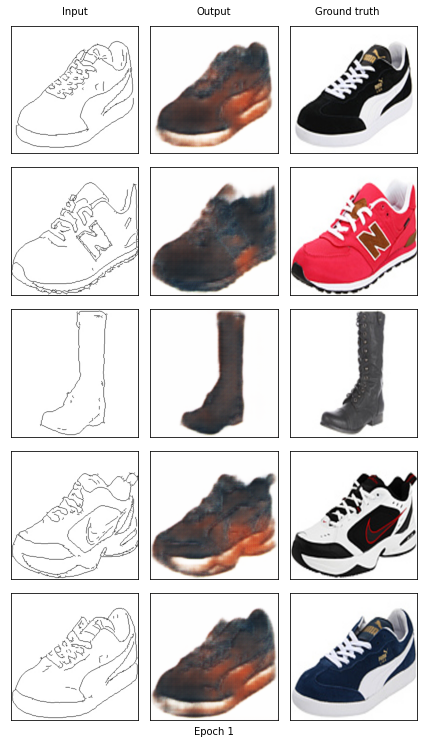

Start training epoch 2
[2/20] - using time: 127.74 seconds
loss of discriminator D: 0.484
loss of generator G: 20.506
Start training epoch 3
[3/20] - using time: 127.89 seconds
loss of discriminator D: 0.488
loss of generator G: 19.495
Start training epoch 4
[4/20] - using time: 127.63 seconds
loss of discriminator D: 0.505
loss of generator G: 18.194
Start training epoch 5
[5/20] - using time: 127.73 seconds
loss of discriminator D: 0.522
loss of generator G: 16.598


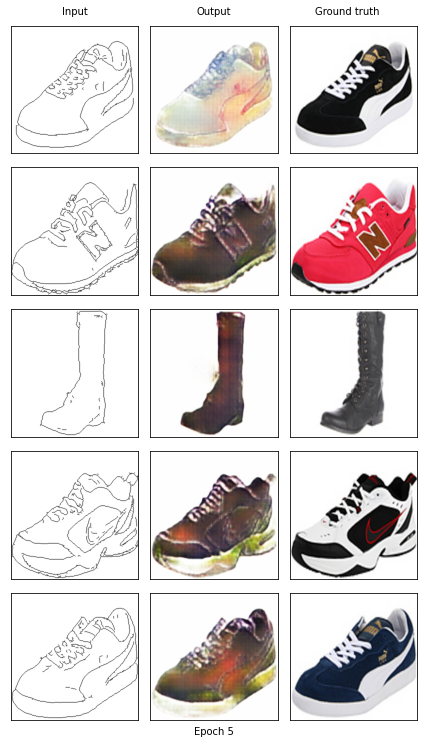

Start training epoch 6
[6/20] - using time: 127.95 seconds
loss of discriminator D: 0.534
loss of generator G: 15.994
Start training epoch 7
[7/20] - using time: 127.80 seconds
loss of discriminator D: 0.543
loss of generator G: 14.495
Start training epoch 8
[8/20] - using time: 127.74 seconds
loss of discriminator D: 0.542
loss of generator G: 13.564
Start training epoch 9
[9/20] - using time: 127.83 seconds
loss of discriminator D: 0.547
loss of generator G: 12.692
Start training epoch 10
[10/20] - using time: 128.11 seconds
loss of discriminator D: 0.549
loss of generator G: 11.984


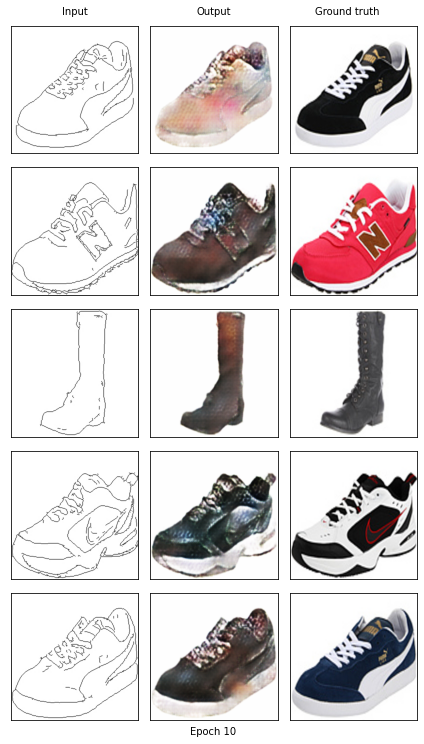

Start training epoch 11
[11/20] - using time: 128.83 seconds
loss of discriminator D: 0.546
loss of generator G: 11.348
Start training epoch 12
[12/20] - using time: 128.74 seconds
loss of discriminator D: 0.559
loss of generator G: 10.766
Start training epoch 13
[13/20] - using time: 128.61 seconds
loss of discriminator D: 0.561
loss of generator G: 10.249
Start training epoch 14
[14/20] - using time: 128.75 seconds
loss of discriminator D: 0.555
loss of generator G: 10.008
Start training epoch 15
[15/20] - using time: 128.71 seconds
loss of discriminator D: 0.572
loss of generator G: 9.601


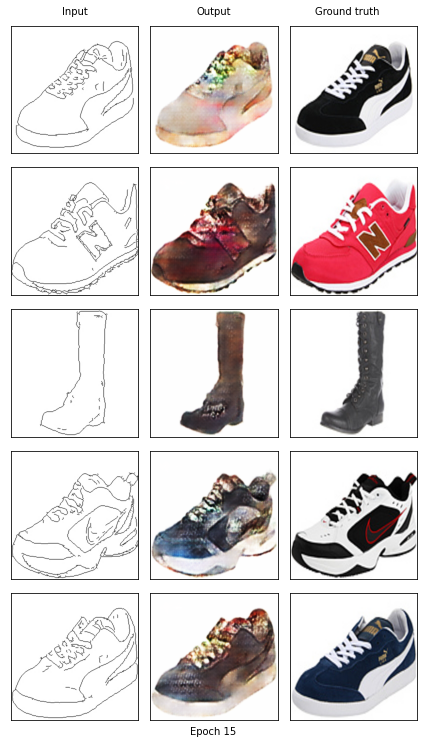

Start training epoch 16
[16/20] - using time: 127.36 seconds
loss of discriminator D: 0.568
loss of generator G: 9.151
Start training epoch 17
[17/20] - using time: 127.33 seconds
loss of discriminator D: 0.568
loss of generator G: 8.941
Start training epoch 18
[18/20] - using time: 126.94 seconds
loss of discriminator D: 0.572
loss of generator G: 8.673
Start training epoch 19
[19/20] - using time: 127.47 seconds
loss of discriminator D: 0.573
loss of generator G: 8.408
Start training epoch 20
[20/20] - using time: 127.01 seconds
loss of discriminator D: 0.584
loss of generator G: 8.148


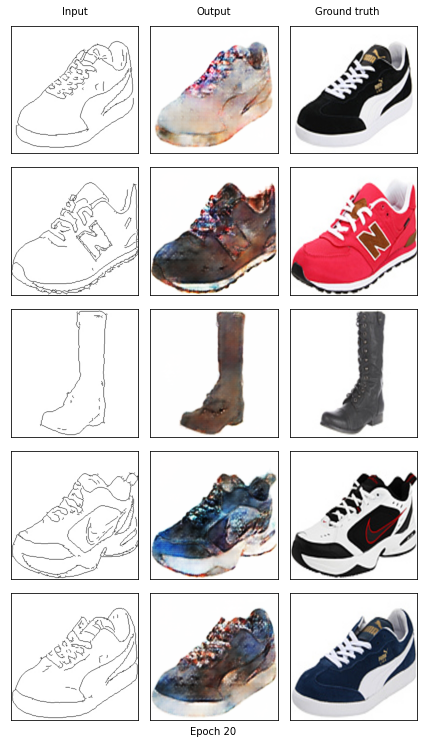

In [15]:
# training
# TODO: change num_epochs if you want
hist_D_100_losses, hist_G_100_BCE_losses, hist_G_100_L1_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [16]:
!mkdir models
if Pokemon_trainer:
  torch.save(G_100.state_dict(), './models/G_100_pokemon.pth')
  torch.save(D_100.state_dict(), './models/D_100_pokemon.pth')
else:
  torch.save(G_100.state_dict(), './models/G_100.pth')
  torch.save(D_100.state_dict(), './models/D_100.pth')

In this part, train your model with only L1 loss with 10 epochs.

training start!
Start training epoch 1
[1/10] - using time: 119.77 seconds
loss of discriminator D: 0.328
loss of generator G: 0.254


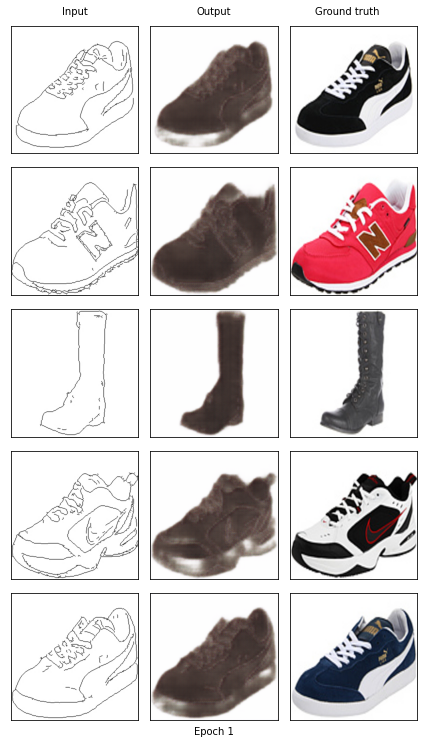

Start training epoch 2
[2/10] - using time: 118.96 seconds
loss of discriminator D: 0.250
loss of generator G: 0.185
Start training epoch 3
[3/10] - using time: 119.15 seconds
loss of discriminator D: 0.075
loss of generator G: 0.171
Start training epoch 4
[4/10] - using time: 119.06 seconds
loss of discriminator D: 0.092
loss of generator G: 0.164
Start training epoch 5
[5/10] - using time: 119.18 seconds
loss of discriminator D: 0.083
loss of generator G: 0.151


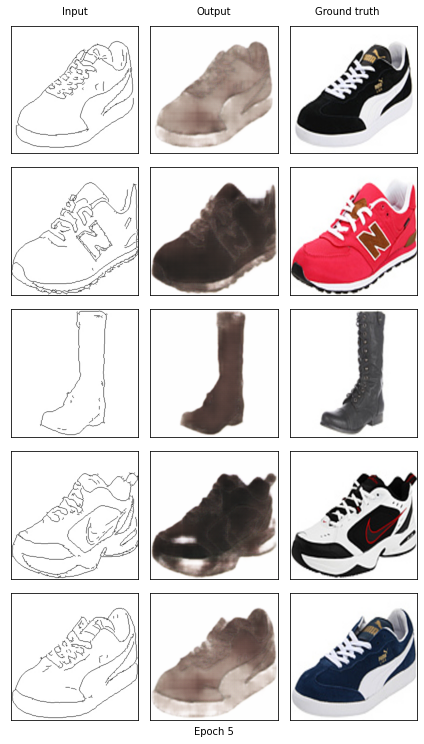

Start training epoch 6
[6/10] - using time: 120.24 seconds
loss of discriminator D: 0.009
loss of generator G: 0.137
Start training epoch 7
[7/10] - using time: 120.12 seconds
loss of discriminator D: 0.068
loss of generator G: 0.131
Start training epoch 8
[8/10] - using time: 120.12 seconds
loss of discriminator D: 0.084
loss of generator G: 0.123
Start training epoch 9
[9/10] - using time: 120.23 seconds
loss of discriminator D: 0.026
loss of generator G: 0.114
Start training epoch 10
[10/10] - using time: 120.23 seconds
loss of discriminator D: 0.003
loss of generator G: 0.106


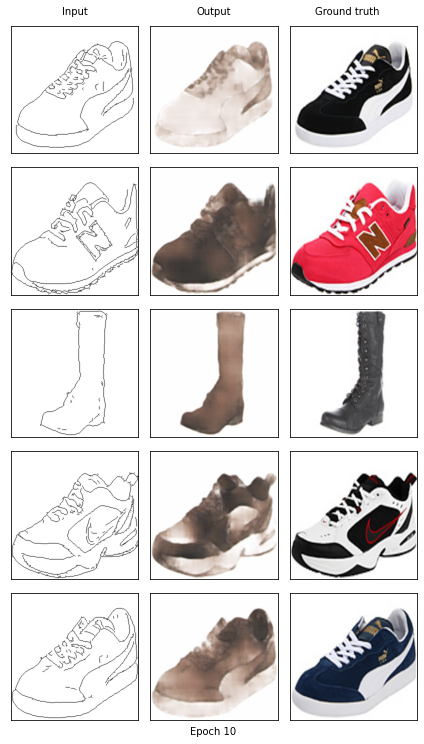

In [17]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

# training
hist_D_L1_losses, hist_G_L1_losses, _ = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

In [18]:
torch.save(G_L1.state_dict(), './models/G_L1.pth')
torch.save(D_L1.state_dict(), './models/D_L1.pth')

The following cell saves the trained model parameters to your Google Drive so you could reuse those parameters later without retraining.

In [19]:
from google.colab import drive
drive.mount('/content/drive')
!cp "./models/" -r "/content/drive/My Drive/"

Mounted at /content/drive


### **TODO**: Please comment on the quality of generated images from L1+cGAN and L1 only:

Images generated from L1+cGAN model has more detail and color, whereas images generated from L1 only lacks color.

## Step 4: Visualization



Please plot the generator BCE and L1 losses, as well as the discriminator loss. For this, please use c=100, and use 3 separate plots.

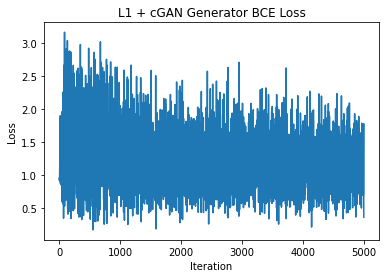

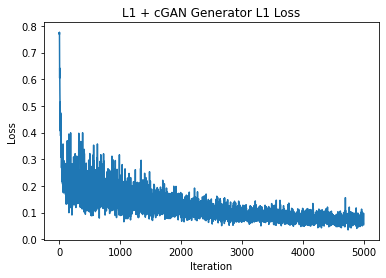

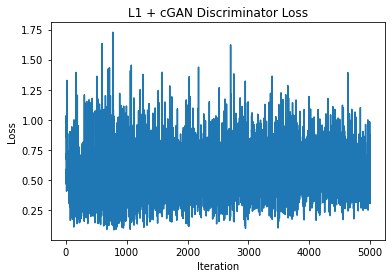

In [20]:
# plot the G/D loss history vs. Iteration
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 
plt.figure()
plt.title('L1 + cGAN Generator BCE Loss')
plt.plot(hist_G_100_BCE_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('L1 + cGAN Generator L1 Loss')
plt.plot(hist_G_100_L1_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('L1 + cGAN Discriminator Loss')
plt.plot(hist_D_100_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 

In this section, plot the G/D loss history vs. Iteration of model with only L1 loss in 2 seperate plots.

Text(0, 0.5, 'Loss')

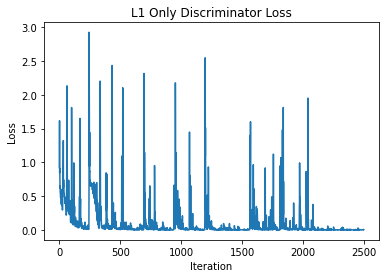

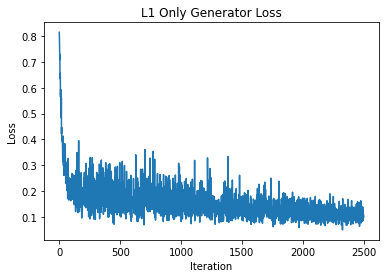

In [21]:
# plot the G/D loss history vs. Iteration in one plot
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 
plt.figure()
plt.title("L1 Only Discriminator Loss")
plt.plot(hist_D_L1_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.figure()
plt.title("L1 Only Generator Loss")
plt.plot(hist_G_L1_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 

### **TODO**: Please comment on the loss plots for L1+cGAN and L1 only models:

The L1 only plot has higher values of discriminator loss than the L1+cGAN plot. The loss plots for the generators among the L1+cGAN and L1 only plots are similar.

## Step 5: Design Your Shoe/Pokemon

Now you can sketch your dream shoes/Pokemon and let the trained model generate them for you! Try to be creative!

In [ ]:
# Build a panel that allows sketching in Colab
# Source: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  print('Please sketch below.')
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
      f.write(binary)
  return len(binary)

if Pokemon_trainer:
  !mkdir pokemon/custom
else:
  !mkdir mini-edges2shoes/custom
!apt-get --quiet install imagemagick

In [ ]:
# Press left mouse button and drag your mouse to draw a sketch.
# Then click Finish.
draw(w=256, h=256)
!convert drawing.png drawing.jpg

# save the drawing to dataset folder as a jpg image
img = np.asarray(Image.open('drawing.png'))
img = 255 - img

if Pokemon_trainer:
  image.imsave('./pokemon/custom/drawing.jpg', np.repeat(img[:,:,3:], 3, axis=2))
  custom_dt = Edges2Image('./pokemon', 'custom', transform)
else:
  image.imsave('./mini-edges2shoes/custom/drawing.jpg', np.repeat(img[:,:,3:], 3, axis=2))
  custom_dt = Edges2Image('./mini-edges2shoes', 'custom', transform)
custom_loader = DataLoader(custom_dt, batch_size=1, shuffle=False)

Run the following cell to mount your Google Drive. You can retrieve your saved model parameters from your Google Drive.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Optional: for loading saved generator
G_100 = generator().cuda()
# For retrieving the model saved to Google Drive
if Pokemon_trainer:
  G_100.load_state_dict(torch.load('/content/drive/My Drive/models/G_100_pokemon.pth'))
else:
  G_100.load_state_dict(torch.load('/content/drive/My Drive/models/G_100.pth'))
# For retreiving the model saved on Colab (you just finished training)
# if Pokemon_trainer:
#   G_100.load_state_dict(torch.load('./models/G_100_pokemon.pth'))
# else:
#   G_100.load_state_dict(torch.load('./models/G_100.pth'))

G_100.eval()

# process the sketch
for x_ in custom_loader:
  x_ = x_.cuda()[:,:,:,:img_size]
  y_ = G_100(x_)

# visualize the image
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
img_ = process_image(y_[0])
img = process_image(x_[0])
axis[0].imshow(img)
axis[0].axis('off')
axis[1].imshow(img_)
axis[1].axis('off')
plt.show()

# Problem 6.2 calculating receptive field size

Please write down the perceptive field size in in this text cell. 

__Please directly replace $?$ with you answer in the expression below.__

$$ Input $$
$$ \downarrow $$
$$ C64 (\text{receptive field size} = 5.534023 \times 10^{19}) $$
$$ \downarrow $$
$$ C128(\text{receptive field size}= 1.020847 \times 10^{39}) $$
$$ \downarrow $$
$$ C256(\text{receptive field size}= 3.473763 \times 10^{77}) $$
$$ \downarrow $$
$$ C512(\text{receptive field size}= 1537) $$

# Convert Notebook to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [26]:
# generate pdf
%%capture
!git clone https://gist.github.com/bc5f1add34fef7c7f9fb83d3783311e2.git
!cp bc5f1add34fef7c7f9fb83d3783311e2/colab_pdf.py colab_pdf.py
from colab_pdf import colab_pdf
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
colab_pdf('cktran_09859713.ipynb')